Authors: Andrea Proia, Federico Spurio, Cristian Urbinati

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/NLP/project'

/content/drive/MyDrive/NLP/project


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Callable, Dict
from collections import OrderedDict
from itertools import groupby
import datetime

import os
import re
import unicodedata
import ast

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

1. dataset creation
2. dataframe frome dataset adding tone and sentiment extracted from ibm funtion
3. split in train/ valid/ test
4. sentence embeddig
5. model that accept sentence, tone and stance to do regression on impact -> maybe sucks
6. add also the father node to the dataset (the post from which the current claim has been generated) and its impact
7. try to combine sentece embeddin of the claim and its father with also the cosine similarity and add all new parameters to the model input
8. think/ search for other attention mechanisms that can be coherent with the information that can be retrieved also in the test set

extension (?):
9. try to implement other mechanisms like SVM comparing results


# Dataset creation

In [4]:
abortion1 = "pro-con-abortion"
abortion2 = "abortion-banned"
ubi = "ubi"
religion = 'religion'

In [5]:
df = pd.DataFrame()

# Religion

In [6]:
debate_list = ['god-exists.CSV', 'has-religion-been-a-good-thing-for-humanity.CSV', 'people-should-not-follow-any-specific-religion.CSV', 'the-existence-of-god.CSV']

In [7]:
for debate in debate_list:
  dataset_csv = pd.read_csv(os.path.join(religion, debate), quotechar='"', sep=',', encoding='cp1252')
  dataset_csv = dataset_csv.drop(columns=['Unnamed: 0'])

  dataset_csv['Claim'] = dataset_csv['Claim'].apply(lambda x: re.sub(r'\[|\]|\(http[\w\W]*?[^\\\)][\)]', '', x).strip().lower())
  dataset_csv['Claim'] = dataset_csv['Claim'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x).strip())
  dataset_csv['Claim'] = dataset_csv['Claim'].apply(lambda x: re.sub(r' +', ' ', x).strip())
  dataset_csv['Debate_name'] = debate.split('.')[0]

  
  df = df.append(dataset_csv, ignore_index=True)

In [8]:
df

,Level,Stance,Claim,Votes,Comments,Depth,Debate_name
0,1,None,the god of classical monotheism omniscient omn...,"['6', '0', '0', '0', '2']",NaN,0,god-exists
1,1.1,pro,kialo discurssion god exists,"['0', '0', '0', '0', '0']",,1,god-exists
2,1.2,pro,there are sound arguments for god,"['2', '1', '0', '0', '1']",2,1,god-exists
3,1.2.1,pro,god is the best explanation for the beginning ...,"['1', '1', '0', '0', '2']",,2,god-exists
4,1.2.1.1,pro,al ghazali s argument kalam cosmological argum...,"['0', '0', '0', '0', '0']",6,3,god-exists
...,...,...,...,...,...,...,...
9760,1.6.10.5,con,empirical evidence need only indicate a confor...,"['0', '0', '0', '0', '0']",,3,the-existence-of-god
9761,1.6.10.5.1,con,a lack of evidence does not indicate that some...,"['0', '0', '0', '0', '0']",,4,the-existence-of-god
9762,1.6.10.5.1.1,pro,for example an expert criminal may not leave a...,"['0', '0', '0', '0', '0']",,5,the-existence-of-god
9763,1.6.10.5.1.1.1,con,this example begs the question by assuming tha...,"['0', '0', '0', '0', '0']",,6,the-existence-of-god


## Complete dataset

In [9]:
df['Votes'] = df['Votes'].apply(lambda x: ast.literal_eval(x))
df['Votes'] = df['Votes'].apply(lambda x: [int(a) for a in x])
df['Tot_votes'] = df['Votes'].apply(lambda x: sum(x))
df['Mean_vote'] = df['Votes'].apply(lambda x: np.average([0,1,2,3,4], weights=[(a + 1e-8) for a in x], axis=0))
df['Mean_vote'] = df['Mean_vote'].apply(lambda x: np.around(x, 1))
df.loc[df['Tot_votes'] == 0, 'Mean_vote'] = 0

In [10]:
def retrieve_parent_claim(level, debate):
  parentLevel = level.rsplit('.', 1)[0]
  return df.loc[(df['Level']  == parentLevel) & (df['Debate_name']  == debate)]['Claim'].values[0] if (len(parentLevel) > 0) else "None"

def retrieve_parent_meanVote(level, debate):
  parentLevel = level.rsplit('.', 1)[0]
  return df.loc[(df['Level']  == parentLevel) & (df['Debate_name']  == debate)]['Mean_vote'].values[0] if (len(parentLevel) > 0) else "None"

def retrieve_parent_stance(level, debate):
  parentLevel = level.rsplit('.', 1)[0]
  return df.loc[(df['Level']  == parentLevel) & (df['Debate_name']  == debate)]['Stance'].values[0] if (len(parentLevel) > 0) else "None"

df["Parent_claim"] = df.apply(lambda row: retrieve_parent_claim(row['Level'], row['Debate_name']), axis=1)
df["Parent_vote"] = df.apply(lambda row: retrieve_parent_meanVote(row['Level'], row['Debate_name']), axis=1)
df["Parent_stance"] = df.apply(lambda row: retrieve_parent_stance(row['Level'], row['Debate_name']), axis=1)

In [11]:
df = df.drop(df[df['Stance'] == 'None'].index)
df = df.drop(df[df['Tot_votes'] < 2].index)
df = df.reset_index()

In [12]:
df

,index,Level,Stance,Claim,Votes,Comments,Depth,Debate_name,Tot_votes,Mean_vote,Parent_claim,Parent_vote,Parent_stance
0,2,1.2,pro,there are sound arguments for god,"[2, 1, 0, 0, 1]",2,1,god-exists,4,1.3,the god of classical monotheism omniscient omn...,1.0,None
1,3,1.2.1,pro,god is the best explanation for the beginning ...,"[1, 1, 0, 0, 2]",,2,god-exists,4,2.2,there are sound arguments for god,1.3,pro
2,5,1.2.1.1.1,pro,p2 there is strong scientific evidence for the...,"[4, 1, 2, 1, 4]",,4,god-exists,12,2.0,al ghazali s argument kalam cosmological argum...,0.0,pro
3,6,1.2.1.1.1.1,pro,the second law of thermodynamics indicates tha...,"[1, 1, 0, 0, 2]",,5,god-exists,4,2.2,p2 there is strong scientific evidence for the...,2.0,pro
4,16,1.2.1.1.1.2,pro,borde guth and vilenkin were able to prove tha...,"[1, 0, 0, 0, 1]",,5,god-exists,2,2.0,p2 there is strong scientific evidence for the...,2.0,pro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,9743,1.6.10.1.1.1,con,this is a false analogy a being such as a deit...,"[1, 0, 0, 0, 2]",,5,the-existence-of-god,3,2.7,empirical evidence cannot indicate the non exi...,0.0,pro
2489,9747,1.6.10.2,pro,issac newton claims that while gravity explain...,"[2, 0, 0, 0, 1]",6,3,the-existence-of-god,3,1.3,empirical evidence can neither prove that god ...,2.1,con
2490,9750,1.6.10.4,con,empirical evidence could trivially prove that ...,"[0, 0, 0, 0, 2]",3,3,the-existence-of-god,2,4.0,empirical evidence can neither prove that god ...,2.1,con
2491,9756,1.6.10.4.3.1,pro,even the empirical observation of a genuine mi...,"[0, 0, 1, 0, 1]",,5,the-existence-of-god,2,3.0,even the direct observation of miracles would ...,3.0,con


Plot some statistics

- La profondità è legata al numero di voti ma non al voto medio
- Utilizzare il numero di voti per pesare il train in modo che dia più importanza alle predizioni sbagliate se nei primi livelli (normalizzati)

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

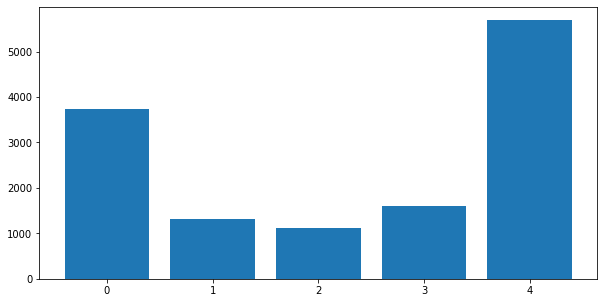

In [14]:
def show_histogram_tot_votes(df):
  '''
  Plot the histogram of votes (in the bins: 0 to 4), given a dataframe with column 'Votes'
  '''
  res = np.zeros(5)
  for v in df['Votes'].values:
    res += v
    
  res = [int(a) for a in list(res)]
  plt.bar(range(0,5), res)
  plt.show()

show_histogram_tot_votes(df)

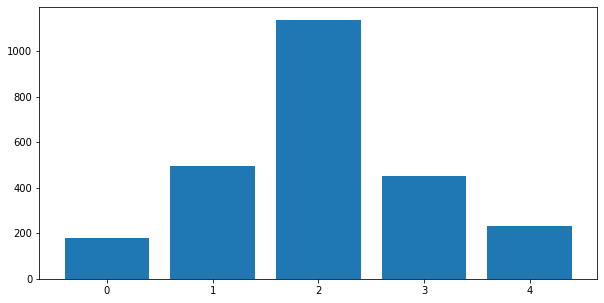

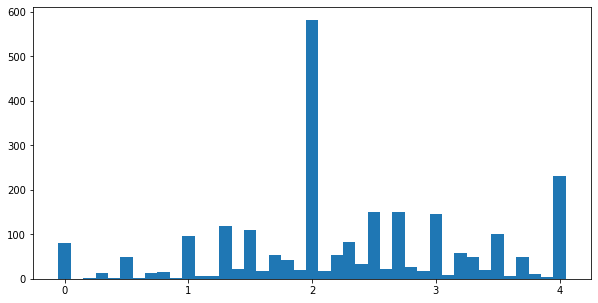

In [15]:
def show_histogram_mean_votes(df):
  d = df['Mean_vote'].values.astype(int)
  plt.bar(*np.unique(d, return_counts=True))
  plt.show()


  d = df['Mean_vote'].values
  plt.bar(*np.unique(d, return_counts=True), width=0.1)
  plt.show()

show_histogram_mean_votes(df)

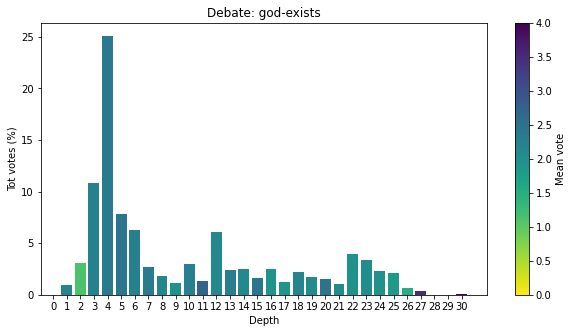

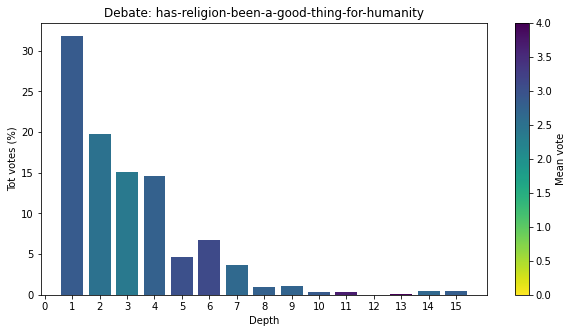

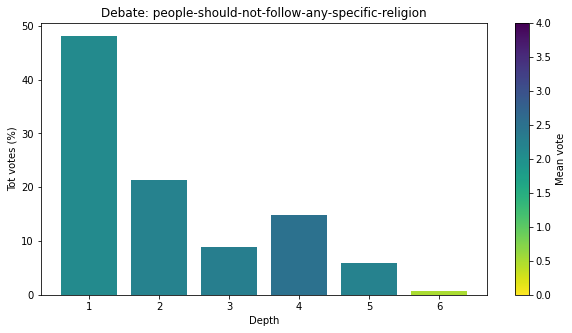

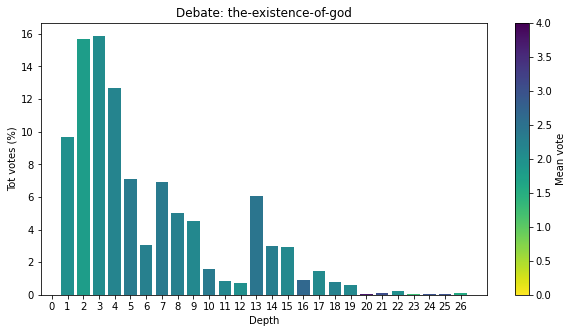

In [16]:
dabate_vs_totVotes = df[['Debate_name', 'Depth','Tot_votes']].groupby(['Debate_name', 'Depth'], as_index=False).sum()
dabate_vs_meanVote = df[['Debate_name', 'Depth','Mean_vote']].groupby(['Debate_name', 'Depth'], as_index=False).mean()

for debate in dabate_vs_totVotes['Debate_name'].unique():
  depths = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Depth'].values
  tot_votes = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Tot_votes'].values
  mean_vote = dabate_vs_meanVote[dabate_vs_meanVote['Debate_name'] == debate]['Mean_vote'].values

  cmap = mpl.cm.viridis_r
  norm = mpl.colors.Normalize(vmin=0, vmax=4)

  plt.title(f'Debate: {debate}')
  plt.xlabel('Depth')
  plt.ylabel('Tot votes (%)')
  plt.xticks(range(max(depths) + 1))
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Mean vote')
  plt.bar(depths, tot_votes/sum(tot_votes) * 100, color=cmap(norm(mean_vote)))
  plt.show()

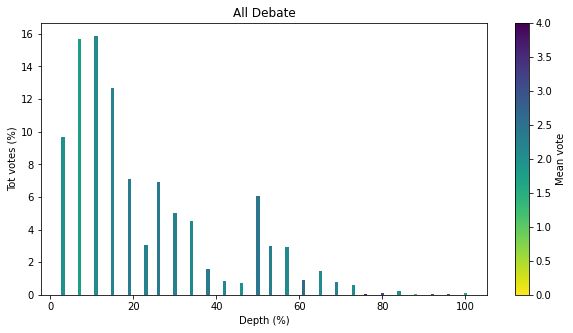

In [17]:
def normalize_by_group(df, by):
    groups = df.groupby(by)
    max = groups.transform("max")
    normalized = df[max.columns] / max * 100
    return normalized.astype(int)

norm_depth = normalize_by_group(df[['Debate_name', 'Depth']], ['Debate_name'])['Depth']
dabate_vs_totVotes = pd.concat([df[['Debate_name','Tot_votes']], norm_depth], axis=1).groupby(['Debate_name', 'Depth'], as_index=False).sum()
dabate_vs_meanVote = pd.concat([df[['Debate_name','Mean_vote']], norm_depth], axis=1).groupby(['Debate_name', 'Depth'], as_index=False).mean()

cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=0, vmax=4)

depths = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Depth'].values
tot_votes = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Tot_votes'].values
mean_vote = dabate_vs_meanVote[dabate_vs_meanVote['Debate_name'] == debate]['Mean_vote'].values

plt.title(f'All Debate')
plt.xlabel('Depth (%)')
plt.ylabel('Tot votes (%)')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Mean vote')
plt.bar(depths, tot_votes/sum(tot_votes) * 100, color=cmap(norm(mean_vote)))
plt.show()

In [18]:
import warnings
warnings.filterwarnings('ignore')

def retrieve_child(level, debate, statement):
  child_level = f'^({level}\.\d+)$'
  children = df.loc[(df['Level'].str.match(child_level)) & (df['Debate_name']  == debate)]
  return children[children['Stance'] == statement]['Stance'].count() if len(children) > 0 else 0

df1 = df[['Debate_name', 'Level']]
df1['Pro'] = df1.apply(lambda row: retrieve_child(row['Level'], row['Debate_name'], 'pro'), axis=1)
df1['Con'] = df1.apply(lambda row: retrieve_child(row['Level'], row['Debate_name'], 'con'), axis=1)

df1

,Debate_name,Level,Pro,Con
0,god-exists,1.2,7,0
1,god-exists,1.2.1,1,0
2,god-exists,1.2.1.1.1,3,0
3,god-exists,1.2.1.1.1.1,0,0
4,god-exists,1.2.1.1.1.2,0,1
...,...,...,...,...
2488,the-existence-of-god,1.6.10.1.1.1,0,0
2489,the-existence-of-god,1.6.10.2,0,0
2490,the-existence-of-god,1.6.10.4,0,0
2491,the-existence-of-god,1.6.10.4.3.1,0,0


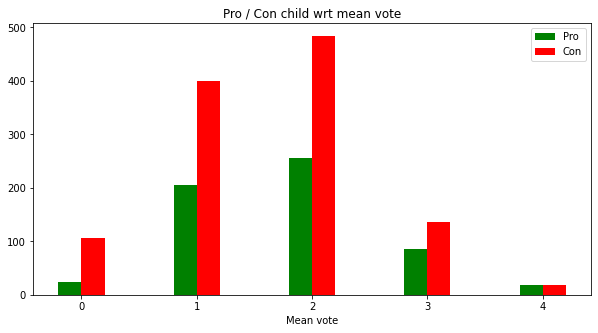

In [20]:
df2 = pd.concat([df1[['Pro', 'Con']], pd.DataFrame(df['Mean_vote'].values.astype(int), columns=['Mean_vote'])], axis=1) 
df2 = df2.groupby(['Mean_vote'], as_index=False).sum()

x = df2['Mean_vote'].values
pro = df2['Pro'].values
con = df2['Con'].values

ax = plt.subplot(111)
ax.bar(x-0.1, pro, width=0.2, color='g', align='center', label='Pro')
ax.bar(x+0.1, con, width=0.2, color='r', align='center', label='Con')

ax.legend()

plt.title(f'Pro / Con child wrt mean vote')
plt.xlabel('Mean vote')

plt.show()

# Split

In [21]:
train = df.sample(frac=0.9, random_state=42)
tmp = df.drop(train.index)
valid = tmp.sample(frac=0.5, random_state=42)
test = tmp.drop(valid.index)

In [22]:
print(train.shape)
print(valid.shape)
print(test.shape)

(2244, 13)
(124, 13)
(125, 13)


#Dataset Conversion
In this section we define the functions that build the vocabulary of terms contained in Claims and Evidences. In particular the function creates two dictionaries: one to retrieve the index given a word and one to obatain the word given an index.

The function is incremental, so, if it is called without the previously mentioned two dictionaries, it creates new ones while if we already have a vocabulary it enriches it with new unseen words.

We encode at the initialization of the vocabulary the reserved string `-PAD-` with index `0` that will be used, as the name suggest, for the padding.

This vocabulary will be used by the tokenizers in order to translate strings into numerical format so that the NN can accept them as input. 



In [23]:
def build_word_vocabulary(df: pd.DataFrame, word_to_idx=None, idx_to_word=None):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :param idx_to_word: existing vocabulary from index to word
    :param word_to_idx: existing vocabulary from word to index
    
    :return:
      - idx_to_word: updated vocabulary from index to word
      - word_to_idx: updated vocabulary from word to index
      - word listing: set of unique terms that build up the vocabulary
      - max_claim_len: max length among all the claims
      - max_evidence_len: max length among all the evidences
    """

    curr_idx = 1
    # vocabularies must be both evaluated or None
    assert (word_to_idx is None and idx_to_word is None) or (word_to_idx is not None and idx_to_word is not None)

    # If no vocabulary passed, then build one
    if word_to_idx is None and idx_to_word is None:
      idx_to_word = OrderedDict()
      word_to_idx = OrderedDict()
      # Reserved word in the dictionary for padding
      word_to_idx["-PAD-"] = 0
      idx_to_word[0] = "-PAD-"
    else:
      curr_idx = max(idx_to_word.keys()) + 1


    # claim
    max_claim_len = 0
    for sentence in tqdm(df['Claim'].values):
      splitted_sentece = sentence.split(" ")
      max_claim_len = max(len(splitted_sentece), max_claim_len)
      for word in splitted_sentece:
        if word not in word_to_idx:
            word_to_idx[word] = curr_idx
            idx_to_word[curr_idx] = word
            curr_idx += 1

    # parentClaim
    for sentence in tqdm(df['Parent_claim'].values):
      splitted_sentece = sentence.split(" ")
      max_claim_len = max(len(splitted_sentece), max_claim_len)
      for word in splitted_sentece:
        if word not in word_to_idx:
            word_to_idx[word] = curr_idx
            idx_to_word[curr_idx] = word
            curr_idx += 1

    word_listing = list(idx_to_word.values())

    return idx_to_word, word_to_idx, word_listing, max_claim_len
 
# Testing: incremental vocabulary
idx_to_word, word_to_idx, word_listing, max_claim_len = build_word_vocabulary(train)
idx_to_word, word_to_idx, word_listing, max_claim_len = build_word_vocabulary(valid, word_to_idx, idx_to_word)
idx_to_word, word_to_idx, word_listing, max_claim_len = build_word_vocabulary(test, word_to_idx, idx_to_word)

print("\n")
print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('[Debug] Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(10)]))

100%|██████████| 125/125 [00:00<00:00, 95463.95it/s]



[Debug] Index -> Word vocabulary size: 6976
[Debug] Word -> Index vocabulary size: 6976
[Debug] Some words: [('-PAD-', 0), ('out', 1), ('of', 2), ('a', 3), ('myriad', 4), ('possible', 5), ('scenarios', 6), ('contradictory', 7), ('with', 8), ('god', 9)]


In [24]:
# Download the glove encoder
import gensim
import gensim.downloader as gloader
embedding_model = gloader.load("glove-wiki-gigaword-50")
embedding_dimension = 50

[==================================================] 100.0% 66.0/66.0MB downloaded


In [25]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

# Testing
oov_terms = check_OOV_terms(embedding_model, word_listing)

Print some statistics:

In [26]:
tot_words = len(word_listing)
tot_OOV = len(oov_terms)
print('Total number of words is:\t{}'.format(tot_words))
print('Total number of OOV words is:\t{}'.format(tot_OOV))
print('Percentage of OOV words w.r.t the whole vocabulary: {:.1f}%'.format(tot_OOV / tot_words * 100))

Total number of words is:	6976
Total number of OOV words is:	300
Percentage of OOV words w.r.t the whole vocabulary: 4.3%


We then define the function that builds the embedding matrix.

The embedding matrix is stored inside a parameter of the tokenizer and will be passed later to the embedding layer in order to retrieve the embedding vectors.

The function is called on the entire vocabulary each time it is updated with new words. In particular it checks if, in the pre-trained embedding model, a given word is present or not. If not so, the function generates a random vector with values in the bound [-0.05, 0.05] and same size of the choosen model. In the end the embedding vector is inserted into the matrix in the line corresponding to the index of that word in the vocabulary in order to match with the numeric input of the NN.

In [27]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding dimension: fixed integer embedding dimension 
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        # If the word is not in the vocabulary, associate a random embedding vector, and save it in the embedding matrix
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

# Testing
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, len(word_to_idx), oov_terms)
# print("\nEmbedding matrix shape: {}".format(embedding_matrix.shape))

100%|██████████| 6976/6976 [00:00<00:00, 231883.03it/s]


In [28]:
class Tokenizer(object):
    """ 
      A simple tokenizer that uses the functions: 
      - build_word_vocabulary
      - check_OOV_terms
      - build_embedding_matrix
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None, embedding_model=None):
        if build_embedding_matrix:
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model = embedding_model

        self.embedding_matrix = None
        self.word_to_idx = None
        self.idx_to_word = None

    def build_vocab(self, data, **kwargs):
        #first time with None -> create, otherwise update vocabulary
        self.idx_to_word, self.word_to_idx, word_listing, _ = build_word_vocabulary(data, self.word_to_idx, self.idx_to_word)

        if self.build_embedding_matrix:
            
            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=word_listing)

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.word_to_idx,
                                                           vocab_size=len(self.word_to_idx),        
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms)


    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.word_to_idx),
        }


    def convert_words_to_ids(self, words):
      return [self.word_to_idx[word] for word in words]

    def convert_ids_to_words(self, ids):
      return [self.idx_to_word[id] for id in ids] 

Using the tokenizer we build incrementally the vocabulary and update the embedding matrix:

In [29]:
# Instantiate the tokenizer (V1)
tokenizer = Tokenizer(build_embedding_matrix=True,
                      embedding_dimension=embedding_dimension,
                      embedding_model=embedding_model)

# BUILDING V2 = V1 + train OOV
tokenizer.build_vocab(train)
print(f'Vocabulary size: {tokenizer.get_info()["vocab_size"]}\n')

# BUILDING V3 = V2 + valid OOV
tokenizer.build_vocab(valid)
print(f'Vocabulary size: {tokenizer.get_info()["vocab_size"]}\n')

# BUILDING V4 = V3 + test OOV
tokenizer.build_vocab(test)
print(f'\nVocabulary size: {tokenizer.get_info()["vocab_size"]}\n')

100%|██████████| 2244/2244 [00:00<00:00, 172444.45it/s]

Checking OOV terms...


Building the embedding matrix...


100%|██████████| 6679/6679 [00:00<00:00, 218140.00it/s]


Vocabulary size: 6679



100%|██████████| 124/124 [00:00<00:00, 161770.98it/s]


Checking OOV terms...
Building the embedding matrix...


100%|██████████| 6836/6836 [00:00<00:00, 182062.29it/s]


Vocabulary size: 6836



100%|██████████| 125/125 [00:00<00:00, 142430.86it/s]

Checking OOV terms...


Building the embedding matrix...


100%|██████████| 6976/6976 [00:00<00:00, 163099.87it/s]


Vocabulary size: 6976



We also define two function to encode the labels into numbers (binary) and vice versa

In [30]:
def label2idx(label):
  return {
        'pro': 1,
        'con': 0,
        'None': 1 # TODO: quanto deve valere None, ovvero la stance del main claim
  }[label]

def idx2label(idx):
  return {
        1: 'pro',
        0: 'con',
  }[idx]

And we split the dataset into claims set, evidences set and label set for train/valid/test 

In [31]:
# train
claim_train = [sentence.split(" ") for sentence in train['Claim'].values]
claim_parent_train = [sentence.split(" ") for sentence in train['Parent_claim'].values]
stance_train = train['Stance']
y_train = train['Mean_vote']

# valid
claim_val = [sentence.split(" ") for sentence in valid['Claim'].values]
claim_parent_val = [sentence.split(" ") for sentence in valid['Parent_claim'].values]
stance_val = valid['Stance']
y_val = valid['Mean_vote']

# test
claim_test = [sentence.split(" ") for sentence in test['Claim'].values]
claim_parent_test = [sentence.split(" ") for sentence in test['Parent_claim'].values]
stance_test = test['Stance']
y_test = test['Mean_vote']

In [32]:
idx_to_show =  30 #@param {type:"slider", min:0, max:121739, step:1}
print('Choosen claim of the training set:')
print(claim_train[idx_to_show])
print('Choosen parent claim of the training set:')
print(claim_parent_train[idx_to_show])
print('\nChoosen stance of the training set:')
print(stance_train[idx_to_show])
print('\nChoosen label of the training set:')
print(y_train[idx_to_show])

Choosen claim of the training set:
['the', 'total', 'amount', 'of', 'energy', 'in', 'the', 'universe', 'can', 'be', 'shown', 'to', 'be', '0', 'it', 'simply', 'not', 'evenly', 'distributed']
Choosen parent claim of the training set:
['the', 'second', 'law', 'of', 'thermodynamics', 'indicates', 'that', 'the', 'universe', 'is', 'running', 'out', 'of', 'usable', 'energy', 'if', 'the', 'universe', 'had', 'existed', 'for', 'an', 'infinite', 'number', 'of', 'past', 'days', 'then', 'all', 'usable', 'energy', 'should', 'have', 'disappeared', 'long', 'ago']

Choosen stance of the training set:
con

Choosen label of the training set:
3.7


Finally we encode the inputs of our model and the output label to do the evaluation steps.

We accomplish this task using two functions that convert claims, evidences and labels into a numerical format using the previously defined tokenizer and functions.

The function also pads claims and evidences using zeroes (the encoding of the `-PAD-` string defined in the initialization of the vocabularies) so that they all have the same size.

The maximum length of the sequences is determined by the training set in order to emulate a real scenario where the test set can also have longer sequences than the ones used to train the network. In case a claim or an evidence exceeds that dimension, it is truncated.

In [33]:
def convert_text(texts, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :param tokenizer: an instantiated tokenizer
    :param is_training: whether input texts are from the training split or not
    :param max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """

    text_ids = [tokenizer.convert_words_to_ids(sentence) for sentence in texts]

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

Convert claim

In [34]:
# Train
claim_train, max_tokens = convert_text(claim_train, tokenizer, True)
print("Max sequence length: {}\n".format(max_tokens))
print('X train shape: ', claim_train.shape)

# Val
claim_val = convert_text(claim_val, tokenizer, False, max_tokens)
print('X val shape: ', claim_val.shape)

# Test
claim_test = convert_text(claim_test, tokenizer, False, max_tokens)
print('X test shape: ', claim_test.shape)

Max sequence length: 86

X train shape:  (2244, 86)
X val shape:  (124, 86)
X test shape:  (125, 86)


Convert parent claim

In [35]:
# Train
claim_parent_train = convert_text(claim_parent_train, tokenizer, False, max_tokens)
print("Max sequence length: {}\n".format(max_tokens))
print('X train shape: ', claim_parent_train.shape)

# Val
claim_parent_val = convert_text(claim_parent_val, tokenizer, False, max_tokens)
print('X val shape: ', claim_parent_val.shape)

# Test
claim_parent_test = convert_text(claim_parent_test, tokenizer, False, max_tokens)
print('X test shape: ', claim_parent_test.shape)

Max sequence length: 86

X train shape:  (2244, 86)
X val shape:  (124, 86)
X test shape:  (125, 86)


Convert stance

In [36]:
# Train
stance_train = stance_train.apply(label2idx).values
print('Y train shape: ', stance_train.shape)

# Val
stance_val = stance_val.apply(label2idx).values
print('Y valid shape: ', stance_val.shape)

# Test
stance_test = stance_test.apply(label2idx).values
print('Y test shape: ', stance_test.shape)

Y train shape:  (2244,)
Y valid shape:  (124,)
Y test shape:  (125,)


In [37]:
idx_to_show =  30 #@param {type:"slider", min:0, max:121739, step:1}
print('Choosen claim of the training set:')
print(claim_train[idx_to_show])
print('Choosen parent claim of the training set:')
print(claim_parent_train[idx_to_show])
print('\nChoosen stance of the training set:')
print(stance_train[idx_to_show])
print('\nChoosen label of the training set:')
print(y_train[idx_to_show])

Choosen claim of the training set:
[ 31 444 445   2 446  74  31 154  93  90 447  58  90 448  82 449 120 450
 451   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Choosen parent claim of the training set:
[  31 1555  932    2 1556 3589   16   31  154   12 3580    1    2 3590
  446  249   31  154  532  762   51   34  208  537    2  916 3591  252
  413 3590  446  727  142 3592  892  854    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Choosen stance of the training set:
0

Choosen label of the training set:
3.7


# Model

In [38]:
# Model 1 and 2
class RNNSentenceEmbedding(tf.keras.layers.Layer):
    """
    Create a recurrent sentence embedding layer that using a bidirectional LSTM

    :param embedding_dim: the dimension of the embedding vector
    :param average_all_outputs: if True the entire sequence of the bidirectional
      LSTM is returned and then all the output vectors are averaged, otherwise
      only the last output is returned

    :return
      the sentence embedding vector
    """
    def __init__(self, embedding_dim, average_all_outputs=False, **kwargs):
        super(RNNSentenceEmbedding, self).__init__(**kwargs)
        self.average_all_outputs = average_all_outputs
        self.lstm = Bidirectional(LSTM(embedding_dim, return_sequences=self.average_all_outputs))
        
    def call(self, inputs, average=False): 
        if self.average_all_outputs:
            return tf.reduce_mean(self.lstm(inputs), axis=1)
        else:
            return self.lstm(inputs)


# Model 3
class MLPSentenceEmbedding(tf.keras.layers.Layer):
    """
    Create a MLP sentence embedding layer using a dense layer. At first the input
    with shape [batch_size, max_tokens, embedding_dim] is flattened to 
    [batch_size, max_tokens * embedding_dim] and then it is passed to the dense layer
    that encodes the embedding vector so that the shape of the output matrix is
    [batch_size, embedding_dim]

    :param embedding_dim: the dimension of the embedding vector

    :return
      the sentence embedding vector
    """
    def __init__(self, embedding_dim, **kwargs):
        super(MLPSentenceEmbedding, self).__init__(**kwargs)
        self.flatten = Flatten()
        self.dense = Dense(embedding_dim)

    def call(self, inputs):
        flattened = self.flatten(inputs)
        return self.dense(flattened)


# Model 4
class AvgSentenceEmbedding(tf.keras.layers.Layer):
    """
    Create a sentence embedding layer that simply average the embedding of each word in the sentece

    :return the sentence embedding vector:
    """
    def __init__(self, **kwargs):
        super(AvgSentenceEmbedding, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        return tf.reduce_mean(inputs, axis=1)

In [39]:
class ConcatationMerge(tf.keras.layers.Layer):
  def call(self, claim_sentence_embedding, evidence_sentence_embedding, **kwargs):
      cosine_similarity = Dot(axes=1, normalize=True)([claim_sentence_embedding, evidence_sentence_embedding])
      merged = Concatenate()([claim_sentence_embedding, evidence_sentence_embedding])
      return Concatenate()([merged, cosine_similarity])

class SumMerge(tf.keras.layers.Layer):
  def call(self, claim_sentence_embedding, evidence_sentence_embedding, **kwargs):
    cosine_similarity = Dot(axes=1, normalize=True)([claim_sentence_embedding, evidence_sentence_embedding])
    merged = Add()([claim_sentence_embedding, evidence_sentence_embedding])
    return Concatenate()([merged, cosine_similarity])

class MeanMerge(tf.keras.layers.Layer):
  def call(self, claim_sentence_embedding, evidence_sentence_embedding, **kwargs):
    cosine_similarity = Dot(axes=1, normalize=True)([claim_sentence_embedding, evidence_sentence_embedding])
    merged = Average()([claim_sentence_embedding, evidence_sentence_embedding])
    return Concatenate()([merged, cosine_similarity])

In [40]:
word_embdedding_info = {
      "output_dim": embedding_dimension,
      "input_dim": tokenizer.get_info()['vocab_size'],
      "input_length": max_tokens,
      "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
      "mask_zero": False,
      "trainable": False
    }

In [41]:
training_info = {
    'verbose': 1,
    'epochs': 100,
    'batch_size': 64,
    'callbacks': [
      keras.callbacks.EarlyStopping(monitor='val_loss',
                                    mode='min',
                                    patience=5, 
                                    restore_best_weights=True)]
}

In [42]:
#Plots some graphs on training history
def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    plt.show()

#Train the model
def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training! \nParameters: {}".format(training_info))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

In [43]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dot, Concatenate, Add, Average, Dense, Dropout, Flatten

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 86)]         0           []                               
                                                                                                  
 claim_parent_input (InputLayer  [(None, 86)]        0           []                               
 )                                                                                                
                                                                                                  
 claim_word_embdedding (Embeddi  (None, 86, 50)      348800      ['claim_input[0][0]']            
 ng)                                                                                              
                                                                                              

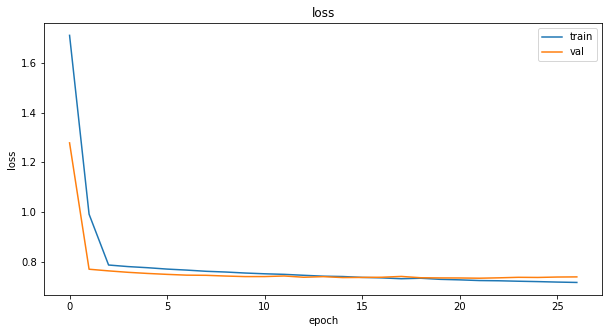

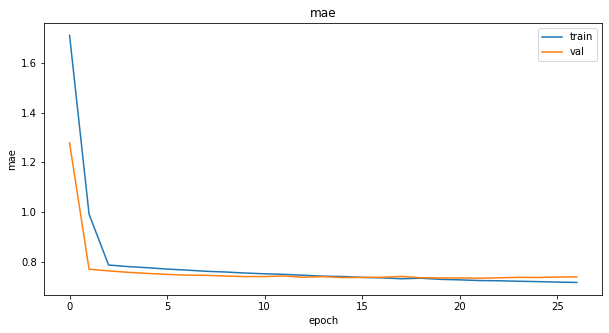

In [44]:
def create_model1(sentence_embedding, merging_strategy):
    
    # Claim input embedding
    claim_input = Input(shape=(max_tokens,), name="claim_input")
    claim_word_embdedding = Embedding(**word_embdedding_info, name="claim_word_embdedding")(claim_input)
    claim_sentence_embedding = sentence_embedding(claim_word_embdedding)

    claim_parent_input = Input(shape=(max_tokens,), name='claim_parent_input')
    claim_parent_word_embdedding = Embedding(**word_embdedding_info, name="claim_parent_word_embdedding")(claim_parent_input)
    claim_parent_sentence_embedding = sentence_embedding(claim_parent_word_embdedding)

    # Stance input
    stance_input = Input(shape=(1,), name='stance_input')

    # Merging
    merge_layer = merging_strategy(claim_sentence_embedding, claim_parent_sentence_embedding)

    # Concatenation
    concat_layer = Concatenate()([merge_layer, stance_input])

    # Regressor
    dense_layer = Dense(50, activation="relu",
                         # kernel_regularizer=keras.regularizers.l2(0.01),
                         name="dense")(concat_layer)
    # Dropout layer
    dropout_layer = Dropout(rate=0, name="dropout")(dense_layer)
    # Output layer
    output_class = Dense(1, activation="relu", name="regressor")(dropout_layer)

    model = keras.Model(inputs=[claim_input, claim_parent_input, stance_input], outputs=output_class)

    model.summary()

    # Compile
    model.compile(loss='mae', metrics=['mae'],
                  optimizer=keras.optimizers.Adam(1e-4))

    return model

model1 = create_model1(sentence_embedding=RNNSentenceEmbedding(embedding_dimension, False, name='sentence_embedding'), merging_strategy=ConcatationMerge(name="merging_strategy"))

model1 = train_model(model=model1, x_train=[claim_train, claim_parent_train, stance_train], y_train=y_train,
                    x_val=[claim_val, claim_parent_val, stance_val], y_val=y_val, training_info=training_info)

# Evaluation

In [48]:
def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: Dict) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """

    #print('Starting prediction: \n{}'.format(prediction_info))
    #print('Predicting on {} samples'.format(x.shape[0]))

    predictions = model.predict(x, **prediction_info)
    return predictions


def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """

    assert len(metrics) == len(metric_names)

    print("Evaluating predictions! Total samples: ", y.shape[0])

    metric_info = {}
    for metric, metric_name in zip(metrics, metric_names):
        all_metric_values = metric
        metric_value = np.mean([ metric(y_true, y_pred) for y_true, y_pred in zip(y, predictions) ])
        metric_info[metric_name] = metric_value

    return metric_info

In [49]:
best_model = model1

In [50]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions = predict_data(model=best_model, x=[claim_test, claim_parent_test, stance_test], prediction_info=prediction_info)

print(test_predictions.shape)
print(y_test.shape)

# test_predictions = np.mean(test_predictions, axis=1)

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

print("\n".join("{} {}".format(x, y) for x, y in zip(test_predictions, y_test)))
# print(test_predictions)
#print(y_test)

2/2 [==============================] - 0s 27ms/step
(125, 1)
(125,)
[2.109093] 3.5
[2.5161328] 2.0
[2.0402536] 2.0
[2.1812012] 1.7
[2.3704] 4.0
[1.833852] 2.0
[2.1177049] 2.0
[2.1287014] 1.3
[2.338225] 2.7
[2.3052323] 0.0
[2.177197] 1.7
[2.3905697] 2.0
[2.3033538] 2.5
[2.06212] 2.3
[2.260884] 4.0
[2.5267832] 2.5
[2.3726685] 3.3
[2.0295825] 2.6
[2.111982] 2.7
[2.4403644] 3.0
[2.3592126] 0.8
[2.237448] 2.0
[2.1389112] 4.0
[1.806607] 2.5
[2.4365435] 3.7
[2.1482284] 4.0
[2.076695] 2.5
[2.2943387] 2.0
[2.0505438] 3.7
[2.5194457] 3.7
[1.9986343] 2.5
[1.9066414] 4.0
[2.0590198] 4.0
[2.061899] 3.7
[2.6795418] 2.0
[2.6001117] 2.0
[2.044237] 3.7
[2.568349] 3.0
[2.7253883] 1.7
[2.580918] 1.0
[2.7075257] 3.3
[2.568447] 3.3
[2.4810748] 3.7
[1.6490288] 4.0
[2.5434425] 2.4
[1.9068149] 2.0
[2.6635354] 2.0
[2.1076128] 2.7
[1.9058571] 1.3
[3.0394733] 0.0
[2.0698533] 0.7
[2.109592] 3.0
[2.0105772] 2.0
[1.7661957] 1.0
[2.5261507] 2.3
[2.2834916] 2.0
[2.3963637] 2.7
[2.664766] 1.5
[2.1982875] 2.3
[2.358503

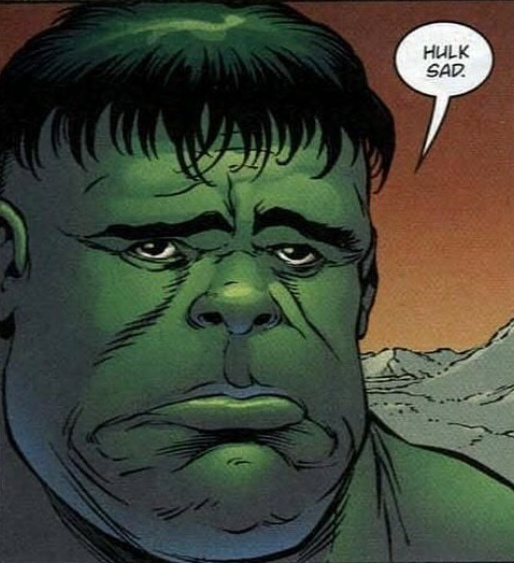